# Анализ оттока клиентов банка "Метанпром"

В данной работе будет произведен анализ клиентов регионального банка "Метанпром", а также будут выделены портреты клиентов, которые склонны уходить из банка

## Материалы
* [Презентация](https://drive.google.com/file/d/177kiz5y-qerMdkAht6qMr59_u891ZfjC/view?usp=sharing)
* [Дашборд](https://public.tableau.com/views/Clienst_Salary_Dash/Clients_Salary_DASH?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

# Описание данных
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Набор данных включает следующие поля:
- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

# Содержание
1. [Загрузка и начальная предобработка данных](#loading_and_preprocessing)
    * [Вывод](#conclusion1)
2. [Исследовательский анализ данных (EDA)](#analysis)
    * [Вывод](#conclusion2)
3. [Построение моделей прогнозирования оттока клиентов](#models_building)
    * [Вывод](#conclusion3)
4. [Кластеризацая клиентов](#clients_clustering)
    * [Вывод](#conclusion4)
5. [Проверка гипотез](#hypothesis_testing)
    * [Вывод](#conclusion5)
6. [Выводы и рекомендации](#conclusion_and_recommendations)

<a id="loading_and_preprocessing"></a>
## Загрузка и начальная предобработка данных

Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
pd.set_option("display.precision", 2)

Датасет хранится в папке `datasets`

In [2]:
bank_data = pd.read_csv('datasets/bank_dataset.csv')

<b>Исследуем данные датасета</b>

In [3]:
def data_info(data: pd.DataFrame) -> None:
    '''
    Функция принимает на вход датафрейм пандас.
    Данные на выходе:
    - Первые пять строк датасета;
    - Подробная информация о датасете;
    - Количество пропущенных значений в датасете;
    - Количество дубликатов в датасете.
    '''
    display(data.head())
    print(data.info())
    print(
        f'Количество пропущенных значений в датасете - {data.isna().sum().sum()}')
    print(f'Количество дубликатов в датасете - {data.duplicated().sum()}')

In [4]:
data_info(bank_data)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
Количество пропущенных значений в датасете - 3617
Количество дубликатов в датасете - 0


Дубликатов в данных нет, но присутсвуют пропущенные значения в cтолбце `Balance`. Также следует привести названия столбцов к нижнему регистру.

<b>Приведем названия столбцов датасета к нижнему регистру</b>

In [5]:
def lower_columns(data: pd.DataFrame) -> list:
    '''
    Функция принимает на вход датафрейм пандас.
    Выходные данные - список из названий столбцов,
    приведенных к нижнему регистру.
    '''
    return [col.lower() for col in data.columns]

In [6]:
bank_data.columns = lower_columns(bank_data)
bank_data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

<b>Исследуем столбец `balance`</b>

Посмотрим на статистические характеристики

In [7]:
bank_data['balance'].describe()

count      6383.00
mean     119827.49
std       30095.06
min        3768.69
25%      100181.98
50%      119839.69
75%      139512.29
max      250898.09
Name: balance, dtype: float64

Среднее и медианное значения практически не отличаются

Посмотрим на пропуски в разрезе по всем признакам

In [8]:
for column in bank_data.columns:
    print(f'Пропущенных занчений в столбце {column}: {bank_data[column].isna().sum()}')

Пропущенных занчений в столбце userid: 0
Пропущенных занчений в столбце score: 0
Пропущенных занчений в столбце city: 0
Пропущенных занчений в столбце gender: 0
Пропущенных занчений в столбце age: 0
Пропущенных занчений в столбце objects: 0
Пропущенных занчений в столбце balance: 3617
Пропущенных занчений в столбце products: 0
Пропущенных занчений в столбце creditcard: 0
Пропущенных занчений в столбце loyalty: 0
Пропущенных занчений в столбце estimated_salary: 0
Пропущенных занчений в столбце churn: 0


Посмотрим какие клиенты присутсвуют в данных с пропущенными значениями

In [9]:
bank_data.query('balance.isna()')['churn'].value_counts(normalize=True)

0    0.86
1    0.14
Name: churn, dtype: float64

Основная часть клиентов относится к неоттоковым(> 80%), и только 14% относится к оттоковым. Так как пропущенных данных много, их нельзя удалять из датасета. Можно предположить, что это либо новые клиенты, которые еще не пользовались банком, либо те, которые перестали пользоваться банком. Но "занулять" пропуски не стоит, так как это отразиться на среднем значении датасета.<br>
Исходя из того, что медианное и среднее значения практически одинаковые, можно заполнить средним значением пропуски относительно группы `objects` - количество объектов в собственности

In [10]:
bank_data['balance'] = bank_data['balance'].fillna(
    bank_data.groupby('objects')['balance'].transform('mean'))

In [11]:
data_info(bank_data)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,120912.81,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,118520.15,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
Количество пропущенных значений в датасете - 0
Количество дубликатов в датасете - 0


<a id="conclusion1"></a>
### Вывод

- Дубликаты в данных не обнаружены, типы столбцов соответсвуют ожиданиям;
- Пропущенные значения в столбце `balance` заполнены средним значенеим отсносительно группы `objects`;
- Названия столбцов приведены к нижнему регистру.

<a id="analysis"></a>
## Исследовательский анализ данных (EDA)

<b>Изучим средние значения и стандартные отклонения. Определим портрет среднестатистического клиента</b>

In [12]:
bank_data.drop(['userid'], axis=1).describe().loc[['mean', 'std']].T

,mean,std
score,650.53,96.65
age,38.92,10.49
objects,5.01,2.89
balance,119835.57,24056.92
products,1.53,0.58
creditcard,0.71,0.46
loyalty,0.52,0.50
estimated_salary,100090.24,57510.49
churn,0.20,0.40


Портрет среднестатистического клиента:
- Возратс клиента - 39 лет;
- Количество объектов в собственности - 5 объектов;
- Баланс на счете - примерно 120 тыс. руб.;
- Количество продуктов, которыми пользуется клиент - 2 продукта;
- Большая вероятность использования кредитной карты(>70%);
- Практически равные доли активности/неактивности клиента;
- Заработная плата клиента - 100 тыс. руб.;

<b>Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался</b>

In [13]:
bank_data.drop(['userid'], axis=1).groupby('churn').mean().T

churn,0,1
score,651.85,645.35
age,37.41,44.84
objects,5.03,4.93
balance,119665.81,120499.18
products,1.54,1.48
creditcard,0.71,0.70
loyalty,0.55,0.36
estimated_salary,99738.39,101465.68


Сходства в двух группах по средним значениям параметров:
- Примерно одинаковые значения кредитного скоринга(645-651);
- Примерно одинаковое количество объектов собственности(5шт.);
- Довольно близкие значения по балансу на счёте в банке(120 тыс.руб.);
- Количество продуктов, которыми пользуется клиент в двух группах примерно одинаковые(2);
- Вероятность использования кредитных карт(70%-71%) в дувх группах сильно схожи;
- Размер заработной платы примерно одинаковый(100 тыс.руб).
<br><br>
Различия в двух группах(надежной группы относительно группы оттока) по средним значениям параметров:
<br><br>
- Отличие в возрасте примерно на 7 лет(38-45);
- Отличие в активности клиента на 20%.

<b>Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток), а также отобразим матрицу корреляций</b>

In [14]:
def analysis(data: pd.DataFrame) -> None:
    '''
    Функция для построения гистограмм
    для каждого параметра и матрицы корреляций
    '''
    # строим гистограммы для каждого исследуемого параметра
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(30, 15)
    axes = axes.ravel()
    i = 0
    for column in data:
        axes[i].hist(data[column], edgecolor='black',
                     fill=True, facecolor='purple', bins=20)
        axes[i].set(title='Гистограмма по столбцу ' + column)
        i += 1
    fig.show()

    cm = data.corr()  # вычисляем матрицу корреляций
    plt.figure(figsize=(12, 12))
    # нарисуем тепловую карту с подписями для матрицы корреляций
    sns.heatmap(data=cm, annot=True)

Построим графики и матрцицу корреляций для тех, кто <b>не ушел в отток</b>

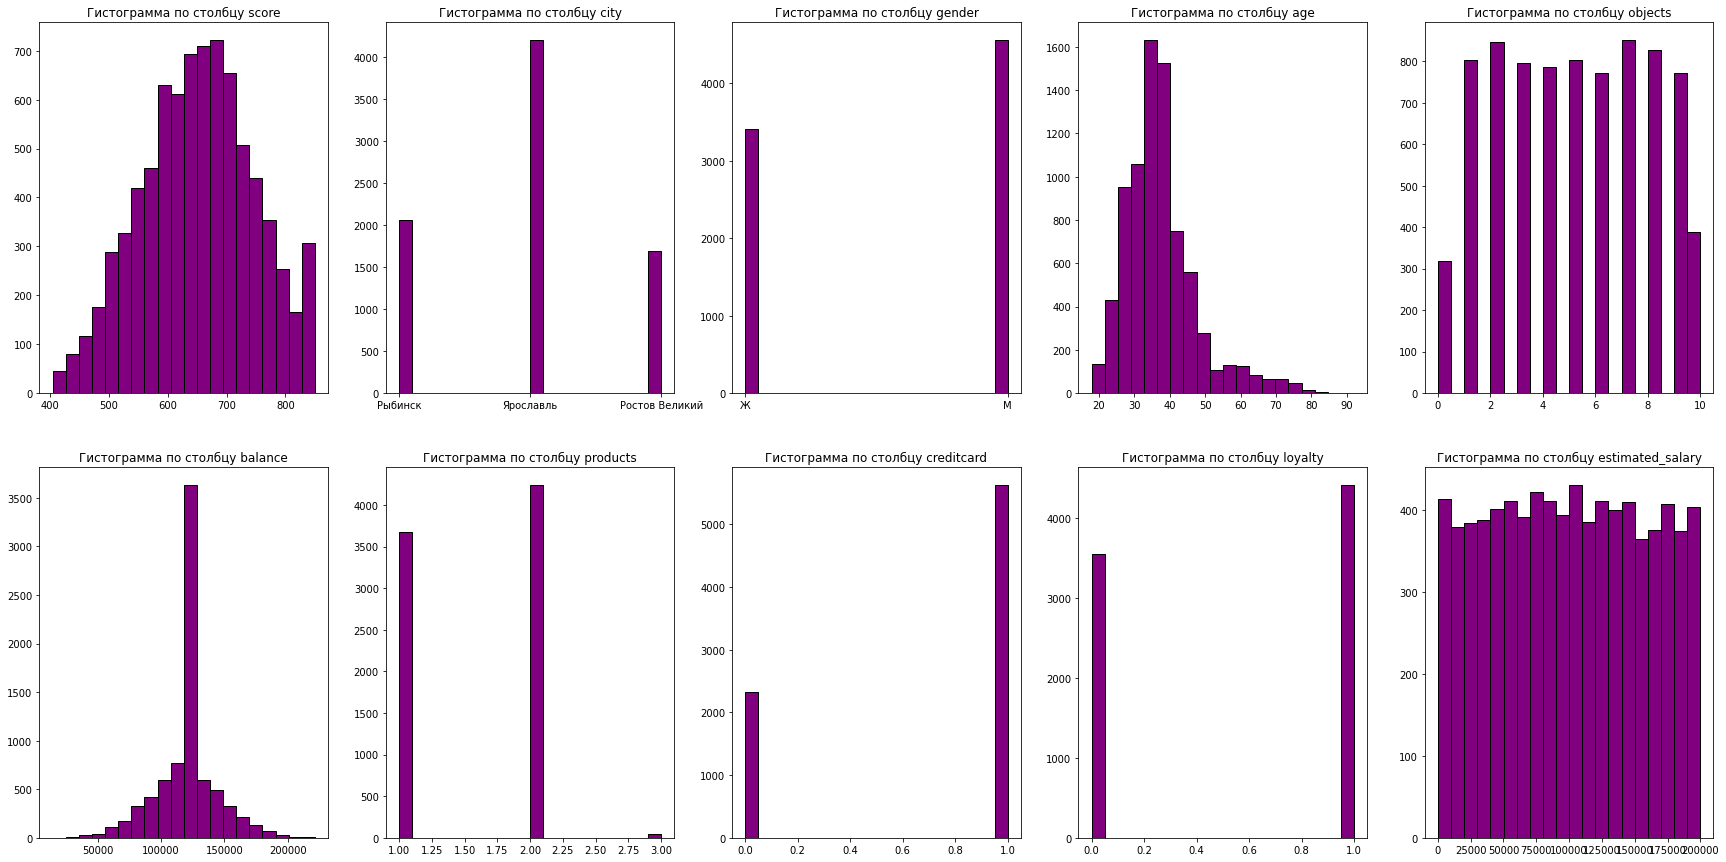

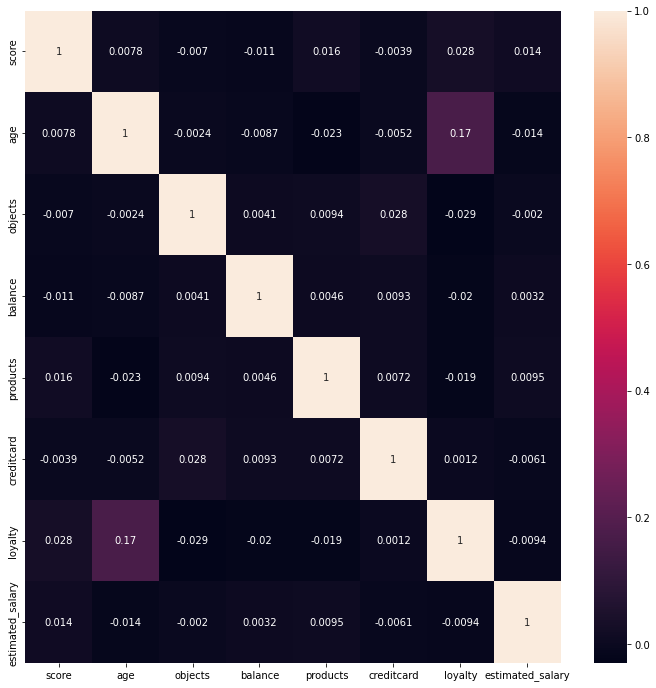

In [15]:
analysis(bank_data.drop(['userid'], axis=1).query(
    'churn==0').drop(['churn'], axis=1))

Построим графики и матрцицу корреляций для тех, кто <b>ушел в отток</b>

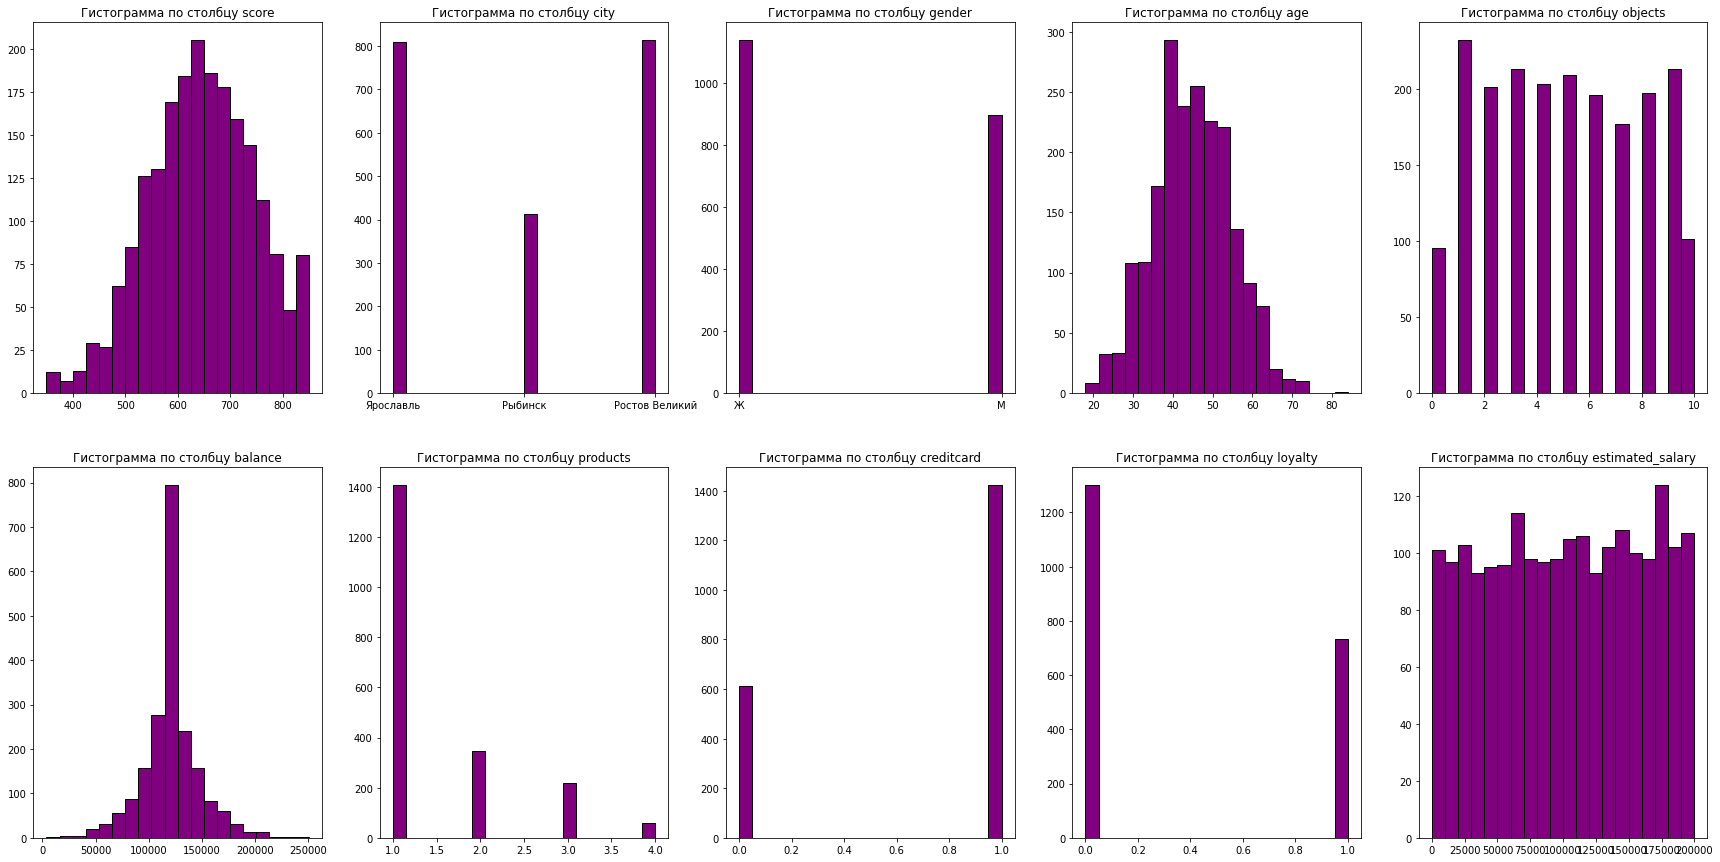

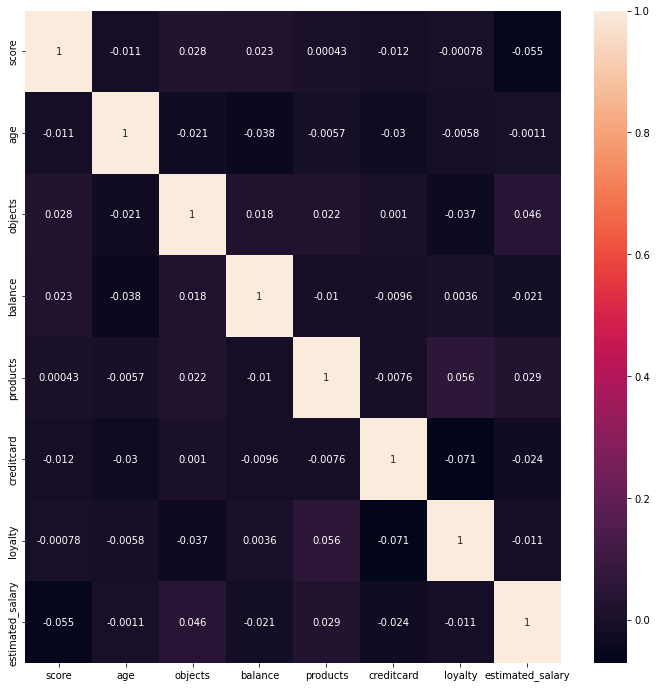

In [16]:
analysis(bank_data.drop(['userid'], axis=1).query(
    'churn==1').drop(['churn'], axis=1))

По диаграммам можно сделать следующие выводы:
- Высокая вероятность оттока у клиентов, которые проживают в Ярославле и Ростове Великом;
- У клиентов женского пола больше вероятность к оттоку;
- Клиенты в возрасте от 40-50 лет имеют тенденцию к оттоку;
- Высокая вероятность оттока у клиентов, которые пользуются только одним продуктом банка;
- Клиенты, которые владеют кредитной картой и являются не совсем активными, имееют тенденцию к оттоку.
<br><br>
Также можно заметить выбросы на некоторых признаках(`balance`, `age`, `score`). Но так как мы работаем с выборкой(срезом данных), удалив выбросы мы можем потерять много данных, что сделает нашу выборку нерепрезентативной.

На матрице корреляций не наблюдаются взаимнокоррелирующие признаки

<b>Построим матрцицу корреляций для всего датасета</b>

<AxesSubplot:>

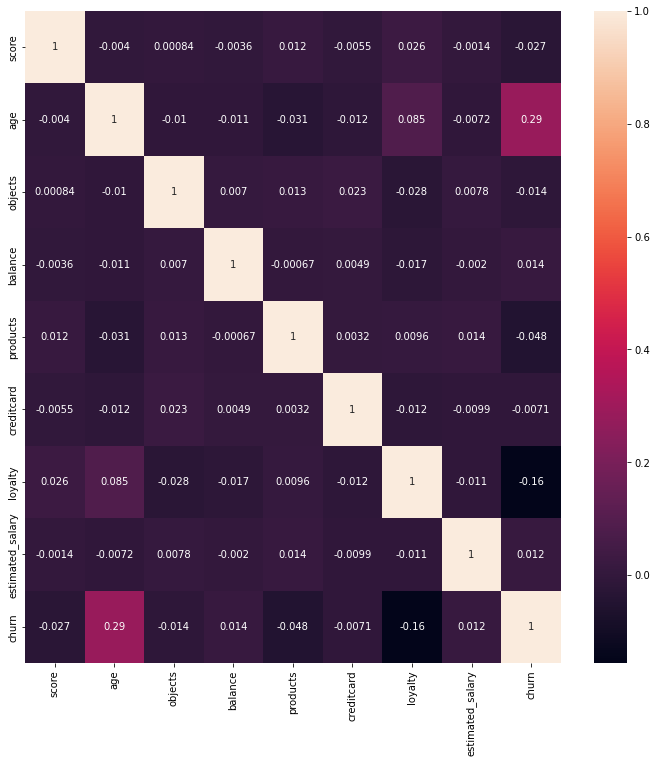

In [17]:
cm = bank_data.drop(['userid'], axis=1).corr()  # вычисляем матрицу корреляций
plt.figure(figsize=(12, 12))
# нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(data=cm, annot=True)

Наблюдается средня корреляция между признаком `age` и целевой переменной `churn`(0.29). Так же можно заметить небольшую отрицательную корреляцию между признаком `loyalty` и целевой переменной `churn`(-0.16)

<a id="conclusion2"></a>
### Вывод

- Составлен портрет среднестатистического клиента;
- Разобраны сходства и различия между оттоковой и надежной группой;<br><br>
По диаграммам можно сделать следующие выводы:
- Высокая вероятность оттока у клиентов, которые проживают в Ярославле и Ростове Великом;
- У клиентов женского пола больше вероятность к оттоку;
- Клиенты в возрасте от 40-50 лет имеют тенденцию к оттоку;
- Высокая вероятность оттока у клиентов, которые пользуются только одним продуктом банка;
- Клиенты, которые владеют кредитной картой и являются не совсем активными, имееют тенденцию к оттоку.
<br><br>
Наблюдается средня корреляция между признаком `age` и целевой переменной `churn`(0.29). Так же можно заметить небольшую отрицательную корреляцию между признаком `loyalty` и целевой переменной `churn`(-0.16)

<a id="models_building"></a>
## Построение моделей прогнозирования оттока клиентов

Преобразуем категориальные поля `city` и `gender` во множество бинарных полей

In [18]:
ml_df = pd.get_dummies(bank_data.drop(['userid'], axis=1))
ml_df.head()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,619,42,2,120912.81,1,1,1,101348.88,1,0,0,1,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,699,39,1,118520.15,2,0,0,93826.63,0,0,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0


<b>Разобьем данные на обучающую и валидационную выборку</b>

In [19]:
X = ml_df.drop(['churn'], axis=1)
y = ml_df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

<b>Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом, а также оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке</b>

In [20]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=100, random_state=0)
]

# функция, которая принимает на вход модель и данные и выводит метрики


def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} ROC_AUC: {:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, probabilities),
        )
    )


for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
Accuracy:0.82 Precision:0.62 Recall:0.23 ROC_AUC: 0.77
RandomForestClassifier(random_state=0)
Accuracy:0.87 Precision:0.77 Recall:0.50 ROC_AUC: 0.85


<a id="conclusion3"></a>
### Вывод

Были применены две модели машинного обучения - Логистическая регрессия и Случайный лес. Модель Случайного леса на метриках "Accuracy", "Precision", "Recall" и "ROC AUC" показала себя лучше и дала относительно неплохие показатели метрик.

<a id="clients_clustering"></a>
## Кластеризацая клиентов

<b>Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму</b>

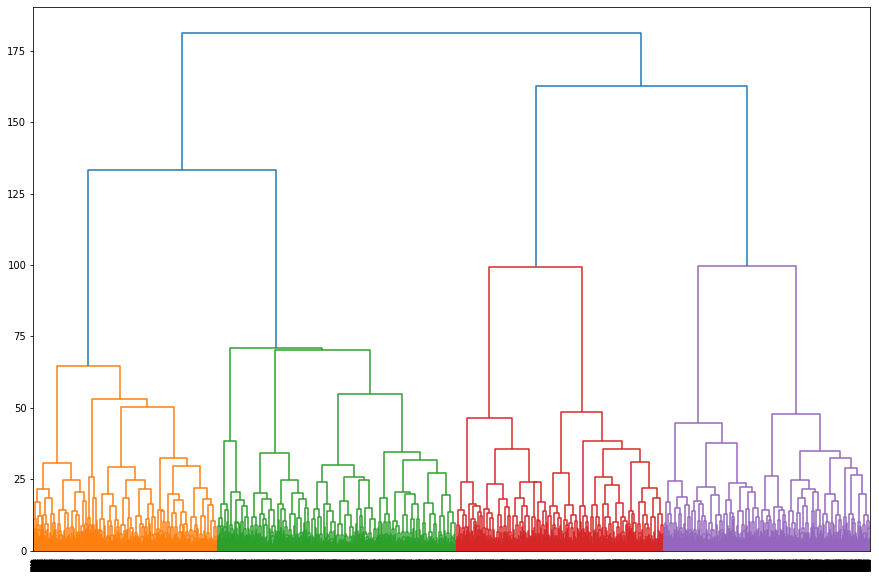

In [21]:
# строим матрицу расстояний функцией linkage()
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method='ward')

# отрисовываем дендограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.show()

Дендограмма выделяет 4 разных цвета, соответсвенно можно выделить 4 кластера. Но визуально можно выделить от 3 до 6 кластеров

<b>Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов</b>

In [22]:
km = KMeans(n_clusters=5, random_state=0)  # задаём число кластеров, равное 5
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc)

Посмотрим на средние значения признаков для кластеров

In [23]:
ml_df['cluster_km'] = labels
bank_data['cluster_km'] = labels
ml_df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
score,650.06,653.09,651.33,649.19,649.97
age,38.30,40.15,38.89,38.77,39.42
objects,5.05,4.97,5.03,4.95,5.05
balance,120551.40,119145.97,119831.78,119085.12,120259.67
products,1.52,1.51,1.54,1.55,1.53
creditcard,0.71,0.71,0.69,0.70,0.72
loyalty,0.52,0.47,0.53,0.51,0.52
estimated_salary,100174.25,102446.42,99440.57,99564.25,99905.03
churn,0.13,0.38,0.17,0.20,0.28
city_Ростов Великий,0.00,1.00,0.00,0.00,1.00


Признаки `balance`, `objects`, `creditcard`, `estimated_salary` примерно одинаковые во всех кластерах, с незначительными отличиями.

- Группы №1 и №4 имеют наибольшие средние показатели по целевой переменной `churn`, соответсвенно можно сделать выводы, что именно в этих группах больше всего клиентов с повышенной вероятностью на отток. Этим группам характерен средний возраст от 39-40 лет, населенный пункт обеих групп - Ростов Великий, в группе №1, в которую попали только клиенты женского пола, признак `loyalty` меньше 50%;
- Группа №0 показывает себя как самая надежная, относительно среднего значения по столбцу `churn`. Данной группе характерен средний возраст 38-39 лет с признаком `loyalty` выше 50%. В данную группу попали только клиенты мужского пола, проживающие в Ярославле;
- Группа №2 показывает чуть хуже отсноситльно группы №0, но такую группу также можно считать довольно надежной. Данной группе характерен средний возраст 38-39 лет с признаком `loyalty` выше 50%. В данную группы попали представители двух гендеров практически в равных долях, проживающие в Рыбинске;
- Группа №3 занимает промежуточное положение отсносительно групп №1 и №4 и групп №0 и №2, однако эту группу можно счиать надежной относительно оттоковых групп. Данной группе характерен средний возраст 38-39 лет с признаком `loyalty` выше 50%. В данную группы попали представители женского пола, проживающие в Ярославле.

<b>Построим распределения признаков для кластеров</b>

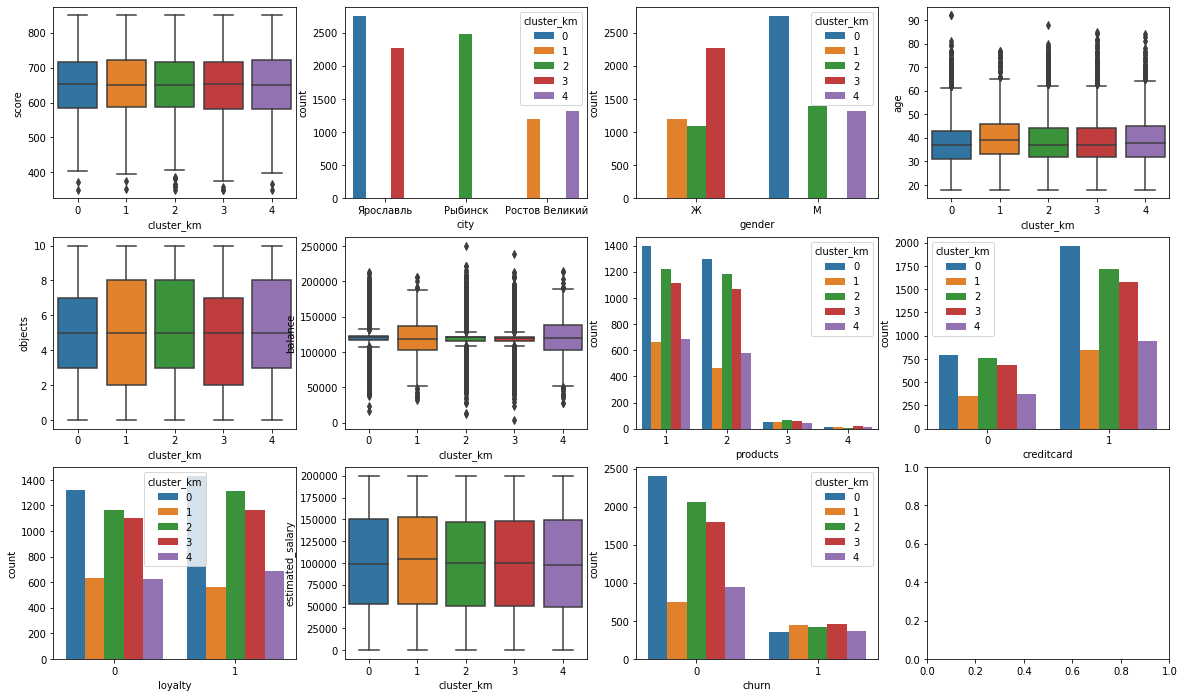

In [24]:
fig, axes = plt.subplots(3, 4)
fig.set_size_inches(20, 12)
axes = axes.ravel()
i = 0
for column in bank_data.drop(['userid'], axis=1):
    if str(bank_data[column].dtype) in ['int64', 'object']:
        if column in ['score', 'age', 'objects']:
            sns.boxplot(x='cluster_km', y=column, data=bank_data, ax=axes[i])
        else:
            sns.countplot(data=bank_data, x=column,
                          hue='cluster_km', ax=axes[i])
    if str(bank_data[column].dtype) == 'float64':
        sns.boxplot(x='cluster_km', y=column, data=bank_data, ax=axes[i])
    i += 1
plt.show()

<b>Для каждого полученного кластера посчитаем долю оттока</b>

In [25]:
ml_df.groupby('cluster_km').agg(
    {'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
cluster_km,
1,0.38
4,0.28
3,0.20
2,0.17
0,0.13


Кластеры №1 и №4 склонны к оттоку, а кластеры №0 и №2 показывают себя довольно надежно. Кластер №3 занимает промежуточное состояние, однако данный кластер можно счиать относительно надежным

<a id="conclusion4"></a>
### Вывод

- Дендограмма выделяет 4 разные группы, соответсвенно для выделяния групп следует брать от 4 до 6 кластеров;
- На модели "K-Means" по графикам и средним значениям признаков - кластеры №1 и №4 выделяются как наиболее вероятные по оттоку;
- Доля оттока в кластерах №1 и №4 высокая, а кластеры №0 и №4 показывают свою надежность;
- Доля оттока в кластере №3 занимает промежуточное состояние относительно потенциально оттоковых и надежных груп.

<a id="hypothesis_testing"></a>
## Проверка гипотез

Посмотрим на размер оттоковых и неоттоковых груп

In [26]:
bank_data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

<b>Гипотеза №1: Средний доход между теми клиентами, которые ушли и теми, которые остались, различается</b>

Нулевая гипотеза "H0" - Средний доход между группами не различается
Альтернативная гипотеза "H1" - Средний доход между группами различается

In [27]:
churn_rate0_salary = bank_data.query('churn==0')['estimated_salary']
churn_rate1_salary = bank_data.query('churn==1')['estimated_salary']

alpha = .05  # критический уровень статистической значимости

# указываем параметр equal_var = False, тк размеры выборок отличаются почти в 4 раза
results = st.ttest_ind(
    churn_rate0_salary,
    churn_rate1_salary,
    equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.22892461305145803
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 23%. Статистически значимых различий в среднем доходе между группами нет

<b>Гипотеза №2: Средний баланс на счете в банке между теми клиентами, которые ушли и теми, которые остались, различается</b>

Нулевая гипотеза "H0" - Средний баланс на счете в банке между группми не различается
Альтернативная гипотеза "H1" - Средний баланс на счете в банке между группми различается

In [28]:
churn_rate0_balance = bank_data.query('churn==0')['balance']
churn_rate1_balance = bank_data.query('churn==1')['balance']

alpha = .05  # критический уровень статистической значимости

# указываем параметр equal_var = False, тк размеры выборок отличаются почти в 4 раза
results = st.ttest_ind(
    churn_rate0_balance,
    churn_rate1_balance,
    equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.1957405186301962
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 20%. Статистически значимых различий в среднем балансе на счету в банке между группами нет

<a id="conclusion5"></a>
### Вывод

- Различие между средним доходом оттоковых и неоттоковых клиентов не обнаружено;
- Различие между средним балансом на счете в банке оттоковых и неоттоковых клиентов не обнаружено.

<a id="conclusion_and_recommendations"></a>
## Выводы и рекомендации

Выводы:
- Был сформирован портрет среднестатистического клиента;
- Были выявлены явные отличия оттоковой группы относительно неоттоковой, а именно: отличие в возрасте в среднем - 7лет, отличие в степени активности на 20%;
<br><br>
Помимо явных отличий, датасет был разделен на 5 групп, две из которых показали себя как наиболее вероятные к оттоку. Данным группам свойственно: 
- Высокая вероятность оттока у клиентов, которые проживают в Ярославле и Ростове Великом;
- У клиентов женского пола больше вероятность к оттоку;
- Клиенты в возрасте от 40-50 лет имеют тенденцию к оттоку;
- Высокая вероятность оттока у клиентов, которые пользуются только одним продуктом банка;
- Клиенты, которые владеют кредитной картой и являются не совсем активными, имееют тенденцию к оттоку.
<br><br>
Были посторены две модели машинного обучения, одна из которых показывает хорошие результаты метрик на валидационных данных
<br><br>
Выводы по гипотезам о равенстве средних доходов и о равенстве среднего баланса между оттоковой и неоттоковой группами:
- Различие между средним доходом оттоковых и неоттоковых клиентов не обнаружено;
- Различие между средним балансом на счете в банке оттоковых и неоттоковых клиентов не обнаружено.

Рекомендации:
- Улучшить работу с клиентами, проживающими в Ростове Великом;
- Разработать программу по удержанию клиентов в возрасте от 45лет;
- Улучшить и/или увеличить банковские продукты;
- Для увеличения среднего баланса на счету в банке стоит добавить кэш бек систему;
- Для привлечения активности клиентов следует снижать ставку по ипотекеж;
- Для привлечения клиентов стоит добавить программу инвестиций с открытием инвестиционного счета для каждого заинтересовавшегося клента.